In [42]:
import numpy as np
import skimage
import utils
import pathlib

# For debugging
import matplotlib.pyplot as plt

In [43]:
def otsu_thresholding(im: np.ndarray) -> int:
    """
        Otsu's thresholding algorithm that segments an image into 1 or 0 (True or False)
        The function takes in a grayscale image and outputs a threshold value

        args:
            im: np.ndarray of shape (H, W) in the range [0, 255] (dtype=np.uint8)
        return:
            (int) the computed thresholding value
    """
    assert im.dtype == np.uint8
    ### START YOUR CODE HERE ### (You can change anything inside this block) 
    ## 1 - Compute the histogram ----------
    # Flatten the image to a 1D array
    flat_image = im.ravel() 
    # Compute the histogram
    hist, _ = np.histogram(flat_image, bins=256, range=(0, 256))
    
    ## 2 - Normalize the histogram ----------
    total_pixels = im.size  # Total number of pixels
    hist_normalized = hist / total_pixels  # Divide each bin by the total number of pixels

    ## 3:6 - Iterate through all possible thresholds, finding the optimal threshold ----------
    # Basically find in between variance for each threshold value
    # The biggest in between variance is the optimal solution for the threshold
    # So we just iterate through the whole inter class variance array and find the threshold with the biggest inter class variance 
    max_variance = 0
    optimal_threshold = 0

    ## 3 - Iterate through all possible threshold ----------
    for k in range(256):
        ## 4 - Calculate Class Probabilities (w0, w1) ----------
        # Cumulative sums for class probabilities
        w0 = np.sum(hist_normalized[:(k+1)]) # Background probabilities
        w1 = np.sum(hist_normalized[(k+1):]) # Foreground probabilities

        ## 5 - Compute Class Means (mu0, mu1) ----------
        # avoiding division by zero in edge cases by returning 0 instead

        # Cumulative weighted sum for class means
        # Get all intensity values: [0, 1, ... 254, 255]
        # Get contribution of each intensity value in the selected region: [0, 1, ... 254, 255] * image_grayscale_value_distribution
        # (regions are background (0 - k) and foreground ((k+1) - 256))
        # This tells how much each intensity value contributes to the image 
        # (We basically weigh each intensity in the image)
        # Now we calculate the sum of all weighted intensity values
        # This cumulative weighted sum will be used later on in threshold iteration to find optimal threshold
        
        # Background
        if w0 > 0:
            cumulative_weighted_sum_mu0 = np.sum(np.arange(0, k+1) * hist_normalized[0:(k+1)])       
            mu0 = cumulative_weighted_sum_mu0/w0
        else:
            mu0 = 0
        
        # Foreground
        if w0 > 0:
            cumulative_weighted_sum_mu1 = np.sum(np.arange(k+1, 256) * hist_normalized[(k+1):256])      
            mu1 = cumulative_weighted_sum_mu1/w1
        else:
            mu1 = 0

        ## 6 - Calculate Inter-Class Variance (sigma_B_squared) ----------
        sigma_B_squared = w0 * w1 * (mu0 - mu1) ** 2

        ## 7 - Find optimal threshold ----------
        if sigma_B_squared > max_variance:
            max_variance = sigma_B_squared
            optimal_threshold = k # k is basically Threshold T

    ## 8 - Output the optimal global threshold for background and foreground distinction ----------
    return optimal_threshold
    ### END YOUR CODE HERE ### 

In [44]:
def display_debug_info(im, threshold, segmented_image):
    """
    Display original image, histogram with threshold, and segmented output.

    Args:
        im: Original image.
        threshold: Threshold value used for segmentation.
        segmented_image: Output of the segmentation.
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    ax[0].imshow(im, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Histogram with Threshold
    ax[1].hist(im.ravel(), bins=256, color='gray', alpha=0.7, label="Pixel Intensity")
    ax[1].axvline(threshold, color='red', linestyle='--', label=f"Threshold: {threshold}")
    ax[1].set_title("Histogram with Threshold")
    ax[1].set_xlabel("Pixel Intensity")
    ax[1].set_ylabel("Frequency")
    ax[1].legend()

    # Segmented Output
    ax[2].imshow(segmented_image, cmap='gray')
    ax[2].set_title("Segmented Output")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

Reading image: images\thumbprint.png
Found optimal threshold: 153
Saving image to: image_processed\thumbprint-segmented.png


C:\Users\Martynas\AppData\Local\Temp\ipykernel_99812\2415970345.py:59: RuntimeWarning: invalid value encountered in scalar divide
  mu1 = cumulative_weighted_sum_mu1/w1


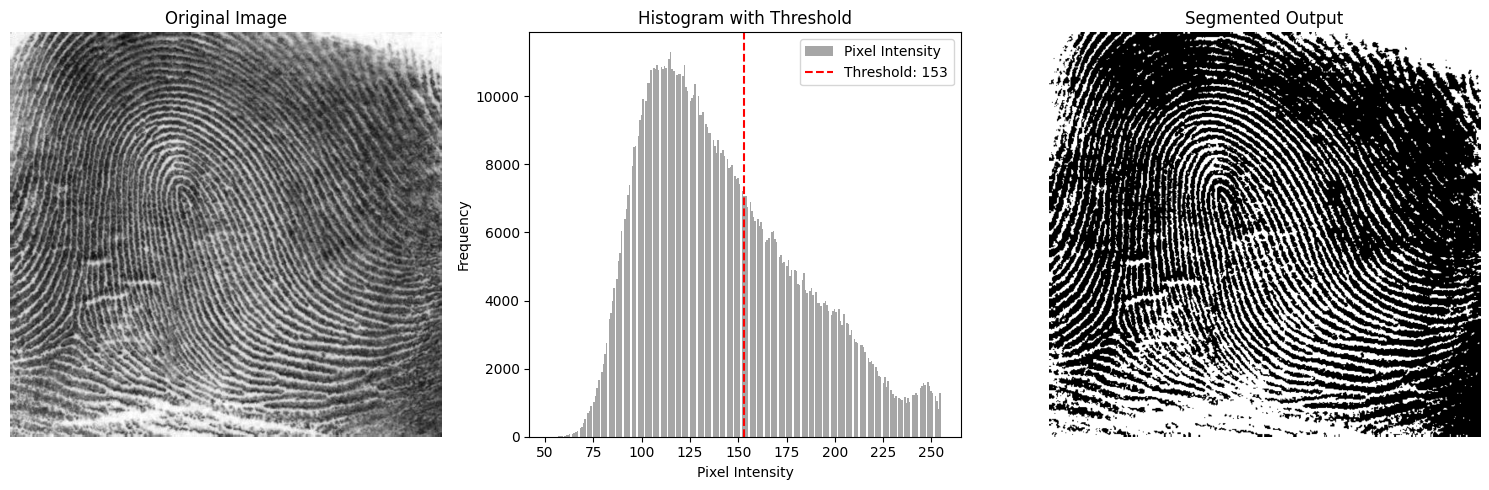

Reading image: images\rice-shaded.png
Found optimal threshold: 134
Saving image to: image_processed\rice-shaded-segmented.png


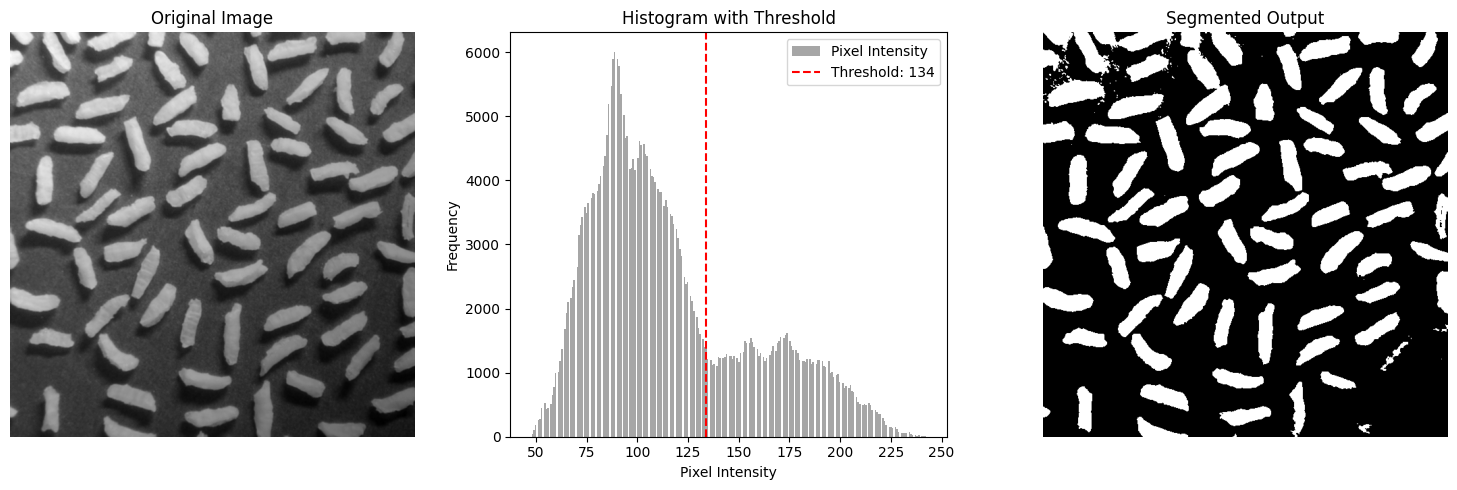

In [45]:
if __name__ == "__main__":
    # DO NOT CHANGE
    impaths_to_segment = [
        pathlib.Path("thumbprint.png"),
        pathlib.Path("rice-shaded.png")
    ]
    for impath in impaths_to_segment:
        im = utils.read_image(impath)
        threshold = otsu_thresholding(im)
        print("Found optimal threshold:", threshold)

        # Segment the image by threshold
        segmented_image = (im >= threshold)
        assert im.shape == segmented_image.shape, "Expected image shape ({}) to be same as thresholded image shape ({})".format(
                im.shape, segmented_image.shape)
        assert segmented_image.dtype == bool, "Expected thresholded image dtype to be bool. Was: {}".format(
                segmented_image.dtype)

        segmented_image = utils.to_uint8(segmented_image)

        save_path = "{}-segmented.png".format(impath.stem)
        utils.save_im(save_path, segmented_image)

        # Debugging - Display original, histogram with threshold, and segmented output
        display_debug_info(im, threshold, segmented_image)
        
